Install necessary libraries

In [ ]:
!pip3 install tqdm
!pip3 install transformers
!pip3 install plotly
# !pip3 install spacy
# !python3 -m spacy download en_core_web_md
!pip3 install p_tqdm

In [ ]:
import os
import numpy as np
import pandas as pd
import collections
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import ast
from tqdm import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
import tensorflow as tf
import transformers
import matplotlib.pyplot as plt
import re
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print("TF Version: ", tf.__version__)

TF Version:  2.5.0


In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.23.234.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.23.234.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Extract train and test files

In [ ]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('train.csv')
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
test_data = pd.read_csv('test.csv')

(array([ 70., 212., 274., 296., 310., 350., 415., 362., 376., 169.]),
 array([135., 142., 149., 156., 163., 170., 177., 184., 191., 198., 205.]),
 <a list of 10 Patch objects>)

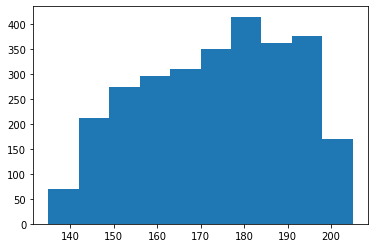

In [ ]:
plt.hist(df.excerpt.apply(lambda x: len(x.split())))

# Text preprocessing - BERT tokenizer

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer.save_pretrained('./bert-base-uncased-tokenizer')

In [ ]:
MAX_SEQ_LENGTH=256
def create_bert_input_features(docs, max_seq_length=MAX_SEQ_LENGTH):
    
    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm(docs):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        segments = [0] * max_seq_length
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)
    encoded = np.array([all_ids, all_masks, all_segments])
    return encoded

In [ ]:
train_features_ids, train_features_masks, train_features_segments,test_features_ids, test_features_masks, test_features_segments={},{},{},{},{},{}
val_features_ids, val_features_masks, val_features_segments={},{},{}

text='excerpt'


train_features_ids[text], train_features_masks[text], train_features_segments[text] =create_bert_input_features(train_data[text].astype(str).tolist())

val_features_ids[text], val_features_masks[text], val_features_segments[text] =create_bert_input_features(val_data[text].astype(str).tolist())

test_features_ids[text], test_features_masks[text], test_features_segments[text] = create_bert_input_features(test_data[text].astype(str).tolist())



100%|██████████| 7/7 [00:00<00:00, 237.67it/s]


# Building Model with pretrained BERT

In [ ]:
# transformers.TFBertModel.from_pretrained("bert-base-uncased").save_pretrained('./bert-base-uncased-model')

In [ ]:
seqlength=MAX_SEQ_LENGTH
with strategy.scope():
  inp_id = tf.keras.layers.Input(shape=(seqlength,), dtype='int32', name="bert_input_ids")
  inp_mask = tf.keras.layers.Input(shape=(seqlength,), dtype='int32', name="bert_input_masks")
  inp_segment = tf.keras.layers.Input(shape=(seqlength,), dtype='int32', name="bert_segment_ids")
  inputs = [inp_id, inp_mask, inp_segment] 

  hidden_state = transformers.TFBertModel.from_pretrained("bert-base-uncased")(inputs)
  pooled_output = hidden_state[0]
  drop_1=tf.keras.layers.Dropout(0.2)(pooled_output)
  lstm=tf.keras.layers.LSTM(256)(drop_1)
  drop=tf.keras.layers.Dropout(0.2)(lstm)
  flat=tf.keras.layers.Flatten()(drop)
  # print(pooled_output.shape)
  output = tf.keras.layers.Dense(1, activation='linear')(flat)
  model = tf.keras.Model(inputs=inputs, outputs=output)
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, 
                                            epsilon=1e-08), 
                loss='mse', metrics=['mse'])
  model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_segment_ids (InputLayer)   [(None, 256)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   bert_input_ids[0][0]             
                                                                 bert_input_masks[0][0]     

# Fine Tuning BERT

In [ ]:
train_labels=train_data['target'].tolist()
val_labels=val_data['target'].tolist()
# test_labels=test_data['target']

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                    patience=1,
                                    restore_best_weights=True
                                    )
model.fit([train_features_ids[text][:,:MAX_SEQ_LENGTH], 
          train_features_masks[text][:,:MAX_SEQ_LENGTH], 
          train_features_segments[text][:,:MAX_SEQ_LENGTH]], np.array(train_labels), 
          epochs=5,
          batch_size=128,
          shuffle=True,
          # validation_data=([val_features_ids[text][:,:MAX_SEQ_LENGTH], 
          # val_features_masks[text][:,:MAX_SEQ_LENGTH], 
          # val_features_segments[text][:,:MAX_SEQ_LENGTH]], np.array(val_labels)),
          validation_split=0.1,
          callbacks=[es],
          verbose=1)

Epoch 1/5


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>]


16/16 [==============================] - ETA: 0s - loss: 1.0169 - mse: 1.0169

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_3:0' shape=(None,) dtype=float32>]


16/16 [==============================] - 158s 5s/step - loss: 1.0169 - mse: 1.0169 - val_loss: 0.6458 - val_mse: 0.6458
Epoch 2/5
16/16 [==============================] - 6s 352ms/step - loss: 0.5258 - mse: 0.5258 - val_loss: 0.6177 - val_mse: 0.6177
Epoch 3/5
16/16 [==============================] - 6s 354ms/step - loss: 0.3781 - mse: 0.3781 - val_loss: 0.4339 - val_mse: 0.4339
Epoch 4/5
16/16 [==============================] - 6s 352ms/step - loss: 0.3050 - mse: 0.3050 - val_loss: 0.3829 - val_mse: 0.3829
Epoch 5/5
16/16 [==============================] - 6s 352ms/step - loss: 0.2518 - mse: 0.2518 - val_loss: 0.4351 - val_mse: 0.4351


# Prediction and Metrics

In [ ]:
val_pred=model.predict([val_features_ids[text][:,:seqlength], val_features_masks[text][:,:seqlength],  val_features_segments[text][:,:seqlength]])

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int64>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int64>]


In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(val_labels, val_pred)

0.341715155492435

In [ ]:
test_pred=model.predict([test_features_ids[text][:,:seqlength], test_features_masks[text][:,:seqlength],  test_features_segments[text][:,:seqlength]])

In [ ]:
result=pd.DataFrame()
result['id']=test_data['id']
result['target']=test_pred

In [ ]:
result

,id,target
0,c0f722661,-0.092518
1,f0953f0a5,-0.352024
2,0df072751,-0.350250
3,04caf4e0c,-1.859666
4,0e63f8bea,-1.507395
5,12537fe78,-0.790981
6,965e592c0,0.506069


In [ ]:
result.to_csv('submission.csv', index=False)